# setup

In [28]:
# import os
# os.environ["http_proxy"] = "http://127.0.0.1:7891"
# os.environ["https_proxy"] = "http://127.0.0.1:7891"

In [29]:
import pandas as pd
import torch
import os
from tqdm.notebook import tqdm
import numpy as np
import re

from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.stats import pearsonr
import random

from scipy.stats import kurtosis

from preprocessing_utils.recommend import *
 
random.seed = 42
np.random.seed(42)

struct = 'lgbm'

search_para = False # パラメータを検索する


In [30]:
anime_df = pd.read_csv('train/anime.csv')
train_df = pd.read_csv('train/train.csv')

test_df = pd.read_csv('test/test.csv')


inter = list(set(train_df.user_id.unique())&set(test_df.user_id.unique()))
print('recommend to:',len(inter))
test_outer = list(set(test_df.user_id.unique())-set(train_df.user_id.unique()))
print('need to predict:',len(inter))
# train_df = anime_info.merge(train_df,on='anime_id')
# test_df = anime_info.merge(test_df,on='anime_id')

train_df.head(5)

recommend to: 1780
need to predict: 1780


,user_id,anime_id,score
0,0008e10fb39e55447333,0669cc0219d468761195,2
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1
3,0008e10fb39e55447333,2290175205d55e81b197,8
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9


# Preprocessing

In [36]:
def weighted_mean(x):
    counts = x.value_counts()
    total = counts.sum()
    weighted_sum = sum(score * count for score, count in counts.items())
    return weighted_sum / total

# 前処理コード
def scaling(data):
    sc = StandardScaler()
    data_sc = np.log1p(data)
    data_sc = sc.fit_transform(data_sc)
    return data_sc

def all_similarity(input_vect):
    # Calculate cosine similarity
    cos_sim = cosine_similarity(input_vect)

    # Calculate Euclidean distance
    euclidean_dist = cdist(input_vect, input_vect, metric='euclidean')

    # Calculate Manhattan distance
    manhattan_dist = cdist(input_vect, input_vect, metric='cityblock')

    # Calculate Jaccard similarity
    jaccard_sim = 1 - pairwise_distances(input_vect, metric='jaccard')

    # Calculate Pearson correlation coefficient
    pearson_corr = np.corrcoef(input_vect, rowvar=True)

    all_dis = np.concatenate([cos_sim,euclidean_dist,manhattan_dist,jaccard_sim,pearson_corr],axis=1)

    return all_dis

def to_minutes(s):

    match = re.search(r'(\d+) hr.*? (\d+) min.', s)
    if match:
        return int(match.group(1)) * 60 + int(match.group(2))
    match = re.search(r'(\d+) min', s)
    if match:
        return int(match.group(1))
    return 1 # for Unknown

def merge_by_anime_id(left_df, right_df):
    return pd.merge(left_df, right_df, on="anime_id", how="left").drop(columns=["anime_id","user_id"])

def merge_by_anime_id_with(left_df, right_df):
    return pd.merge(left_df, right_df, on="anime_id", how="left")


def merge_by_user_id_with(left_df, right_df):
    return pd.merge(left_df, right_df, on="user_id", how="left")

# train_scores = train_df.groupby('anime_id')['score'].apply(weighted_mean)
def create_anime_numeric_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""
    
    use_columns = [
        "members", 
        "watching","completed","on_hold","dropped","plan_to_watch"
    ]
    return merge_by_anime_id(input_df, anime_df)[use_columns]
    # return pd.merge(input_df, anime_df, on="anime_id", how="left").drop(columns=["anime_id","user_id"])


def create_anime_type_one_hot_encoding(input_df):
    
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
        
    out_df["anime_id"] = anime_df["anime_id"]
    
    return merge_by_anime_id(input_df, out_df)
def type(input_df):
    # 単純にラベルエンコーディング
    encoder = LabelEncoder()
    type_encoder = anime_df[['anime_id']].copy()
    type_encoder["type_label"] = encoder.fit_transform(anime_df["type"])
    return merge_by_anime_id(input_df, type_encoder)

def create_anime_type_one_hot_encoding(input_df):
    
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
        
    out_df["anime_id"] = anime_df["anime_id"]
    
    return merge_by_anime_id(input_df, out_df)

def create_anime_type_count_encoding(input_df):
    count = anime_df["type"].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "tyoe_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

def create_licensors_count_encoding(input_df):
    count = anime_df["licensors"].map(anime_df["licensors"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "licensors_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

def studios(input_df):
    # 単純にラベルエンコーディング
    encoder = LabelEncoder()
    studios_encode = anime_df[['anime_id']].copy()
    studios_encode["studios"] = encoder.fit_transform(anime_df["studios"])
    return merge_by_anime_id(input_df, studios_encode)

def create_studio_count_encoding(input_df):
    count = anime_df["studios"].map(anime_df["studios"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "studios_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

def create_source_count_encoding(input_df):
    count = anime_df["source"].map(anime_df["source"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "source_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

def source(input_df):
    # 単純にラベルエンコーディング
    encoder = LabelEncoder()
    source_encode = anime_df[['anime_id']].copy()
    source_encode["source"] = encoder.fit_transform(anime_df["source"])
    return merge_by_anime_id(input_df, source_encode)

def create_rating_count_encoding(input_df):
    count = anime_df["rating"].map(anime_df["rating"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        "rating_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

def create_genres_onehot_encoding(input_df):
    """Create 26-dim embedding"""
    chars = ['Comedy', 'Sci-Fi', 'Seinen', 'Slice of Life', 'Space',
       'Adventure', 'Mystery', 'Historical', 'Supernatural', 'Fantasy',
       'Ecchi', 'School', 'Harem', 'Romance', 'Shounen', 'Action',
       'Magic', 'Sports', 'Super Power', 'Drama', 'Thriller', 'Music',
       'Shoujo', 'Demons', 'Mecha', 'Game', 'Josei', 'Cars',
       'Psychological', 'Parody', 'Samurai', 'Military', 'Shoujo Ai',
       'Kids', 'Martial Arts', 'Horror', 'Dementia', 'Vampire',
       'Shounen Ai', 'Hentai', 'Yaoi', 'Police']
    genres = anime_df[['anime_id','genres']]
    genres.loc[:,chars] = 0
    genres['genres'] = genres['genres'].str.split(',')
    # genres[chars] = 0
    for i, row in genres.iterrows():
        for index in (s.strip() for s in row['genres']):
                genres.loc[i,index] = 1
    genres = genres.drop('genres',axis=1)
    return merge_by_anime_id(input_df, genres)


def create_producer_onehot_encoding(input_df):
    """Create 26-dim embedding"""
    producer = anime_df['producers'].str.split(',')
    all_producer = list(map(str.strip,producer.explode().unique()))
    producer = anime_df[['anime_id']]
    producer.loc[:,all_producer] = 0
    producer['producers'] = anime_df['producers'].str.split(',')
    # genres[chars] = 0
    for i, row in producer.iterrows():
        for index in (s.strip() for s in row['producers']):
                producer.loc[i,index] = 1
    
    return merge_by_anime_id(input_df, producer).drop('producers',axis=1)


def create_anime_type_one_hot_encoding(input_df):
    
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
        
    out_df["anime_id"] = anime_df["anime_id"]
    
    return merge_by_anime_id(input_df, out_df)

def create_duration2min(input_df):
    time_min = anime_df[['anime_id']]
    time_min['minutes'] = anime_df['duration'].apply(to_minutes)
    return merge_by_anime_id(input_df, time_min)
from datetime import datetime
def to_year(s):
    match = re.search(r'\d{4}', s)
    if match:
       return int(match.group())
    else:
        return 1000
    
def year_pre(input_df):
    year = anime_df[['anime_id']]
    encoder = LabelEncoder()
    year['year'] = encoder.fit_transform(anime_df['aired'].apply(to_year))
    
    return merge_by_anime_id(input_df, year)

def merge_embedding(input_df):
    embeds = np.load("train/anime_jpbert_embeddings.npy")
    ids = np.load("train/anime_jpbert_ids.npy")
    embeds_list = []
    for l in range(embeds.shape[0]):
        embeds_list.append(embeds[l,:])
    anime_embed = pd.DataFrame(data={"anime_id": ids, "embed" : embeds_list})
    embed_array = np.array(anime_embed["embed"].tolist())

    for i in range(768):
        anime_embed[f"embed_{i}"] = embed_array[:,i]

    anime_embed.drop("embed", axis=1, inplace=True)
    return merge_by_anime_id(input_df, anime_embed)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist, squareform
import pickle
from gensim.models import word2vec,Word2Vec


def create_tfidf_matrix(input_df,mode='anime'):
    text_columns = ['genres', 'japanese_name', 'type', 'episodes', 'aired', 'producers', 'licensors', 'studios', 'source', 'duration', 'rating']

    tf = TfidfVectorizer()
    try:
        tf = pickle.load(open("vectorizer.pickle", "rb"))
        print('loaded tf')
    except:
        tf.fit(anime_df[text_columns].astype(str).apply(lambda x: ';'.join(x), axis=1).tolist()) 
        pickle.dump(tf, open("vectorizer.pickle", "wb"))
    tfidf_matrix = tf.fit_transform(anime_df[text_columns].astype(str).apply(lambda x: ';'.join(x), axis=1).tolist())
    cosine_sim = all_similarity(tfidf_matrix.toarray()) 
    svd = TruncatedSVD(n_components=30,random_state=42)

    svd_arr = svd.fit_transform(cosine_sim)
    print('tfdf:',svd.explained_variance_ratio_.sum())
    
    col_df = pd.DataFrame(
    svd_arr,
    index=anime_df['anime_id'],
    columns=[f"svd_{mode}_{ix}" for ix in range(30)],
    ).reindex()
    return merge_by_anime_id_with(input_df, col_df)

def create_tf_user_anime_vector(input_df):
    df = pd.concat([train_df,test_df])
    matrix = create_tfidf_matrix(df,mode='user_mean').drop(['anime_id','score'],axis=1)
    user_matrix_mean = matrix.groupby('user_id').mean()
    user_matrix_std = matrix.groupby('user_id').std()
    user_matrix_skew = matrix.groupby('user_id').skew()
    user_matrix_var = matrix.groupby('user_id').var()
    
    
    svd = TruncatedSVD(n_components=20,random_state=42)
    mean_cos = svd.fit_transform(all_similarity(user_matrix_mean.values))
    print('mean_user:',svd.explained_variance_ratio_.sum())
    
    
    user_mean_cos_matrix = pd.DataFrame(mean_cos,
                          index=user_matrix_mean.index.values.tolist(),
                          columns=[f"w2v_mean_user_cos_{i}" for i in range(mean_cos.shape[1])]
                          )
    
    
    user_matrix = pd.concat([user_matrix_mean,user_matrix_std,user_matrix_skew,user_matrix_var,user_mean_cos_matrix],axis=1).reindex()
    user_matrix.index.name='user_id'
    return merge_by_user_id_with(input_df, user_matrix).drop('user_id',axis=1)

def create_llma_anime_vector(input_df,embed_source,mode='anime'):
    embeddings = np.load(f"./train/{embed_source}.npy")
    df_anime_preprocessd = anime_df[['anime_id']].copy()
    svd = TruncatedSVD(n_components=20,random_state=42)
    svd_arr = svd.fit_transform(all_similarity(embeddings))
    
    embeddings_columns = [f"{embed_source}_{mode}_{i}" for i in range(svd_arr.shape[1])]
    embeddings_df = pd.DataFrame(data=svd_arr, columns=embeddings_columns)
    df_anime_preprocessd = df_anime_preprocessd.join(embeddings_df)
    
    return merge_by_anime_id_with(input_df, df_anime_preprocessd)

def create_llma_anime_embed(input_df,embed_source,mode='anime'):
    embeddings = np.load(f"./train/{embed_source}.npy")
    df_anime_preprocessd = anime_df[['anime_id']].copy()
    svd = TruncatedSVD(n_components=20,random_state=42)
    svd_arr = svd.fit_transform(embeddings)
    
    embeddings_columns = [f"{embed_source}_{mode}_embed_{i}" for i in range(svd_arr.shape[1])]
    embeddings_df = pd.DataFrame(data=svd_arr, columns=embeddings_columns)
    df_anime_preprocessd = df_anime_preprocessd.join(embeddings_df)
    
    return merge_by_anime_id_with(input_df, df_anime_preprocessd)


def create_01EDA_user_vector(input_df):
    df = pd.concat([train_df,test_df])
    matrix = create_llma_anime_vector(df,embed_source='mBERT_embedding_01EDA',mode='user_mean').drop(['anime_id','score'],axis=1)
    user_matrix_mean = matrix.groupby('user_id').mean()
    user_matrix_std = matrix.groupby('user_id').std()
    user_matrix_skew = matrix.groupby('user_id').skew()
    user_matrix_var = matrix.groupby('user_id').var()    
    
    svd = TruncatedSVD(n_components=20,random_state=42)
    mean_cos = svd.fit_transform(all_similarity(user_matrix_mean.values))
    print('mean_user:',svd.explained_variance_ratio_.sum())
    
    
    user_mean_cos_matrix = pd.DataFrame(mean_cos,
                          index=user_matrix_mean.index.values.tolist(),
                          columns=[f"w2v_mean_user_cos_{i}" for i in range(mean_cos.shape[1])]
                          )
     
    user_matrix = pd.concat([user_matrix_mean,user_matrix_std,user_matrix_skew,user_matrix_var,user_mean_cos_matrix],axis=1).reindex()
    user_matrix.index.name='user_id'
    
    return merge_by_user_id_with(input_df, user_matrix).drop('user_id',axis=1)

def create_large_user_vector(input_df):
    df = pd.concat([train_df,test_df])
    matrix = create_llma_anime_vector(df,embed_source='mBERT_embedding_large',mode='user_mean').drop(['anime_id','score'],axis=1)
    user_matrix_mean = matrix.groupby('user_id').mean()
    user_matrix_std = matrix.groupby('user_id').std()
    user_matrix_skew = matrix.groupby('user_id').skew()
    user_matrix_var = matrix.groupby('user_id').var()
    # user_matrix_sum = matrix.groupby('user_id').sum()
    
    
    svd = TruncatedSVD(n_components=20,random_state=42)
    mean_cos = svd.fit_transform(all_similarity(user_matrix_mean.values))
    print('mean_user:',svd.explained_variance_ratio_.sum())
    
    # svd = TruncatedSVD(n_components=20,random_state=42)
    # sum_cos = svd.fit_transform(cosine_similarity(user_matrix_sum))
    # print('sum_user:',svd.explained_variance_ratio_.sum())
    
    user_mean_cos_matrix = pd.DataFrame(mean_cos,
                          index=user_matrix_mean.index.values.tolist(),
                          columns=[f"w2v_mean_user_cos_{i}" for i in range(mean_cos.shape[1])]
                          )
    
    # user_sum_cos_matrix = pd.DataFrame(sum_cos,
    #                       index=user_matrix_sum.index.values.tolist(),
    #                       columns=[f"w2v_sum_user_cos_{i}" for i in range(sum_cos.shape[1])]
    #                       )
    # user_embed_mean = create_llma_anime_embed(df,mode='user_mean',embed_source='mBERT_embedding_large').drop(['anime_id','score'],axis=1).groupby('user_id').mean()
    # user_embed_std = create_llma_anime_embed(df,mode='user_std',embed_source='mBERT_embedding_large').drop(['anime_id','score'],axis=1).groupby('user_id').std()
    # user_embed_skew = create_llma_anime_embed(df,mode='user_skew',embed_source='mBERT_embedding_large').drop(['anime_id','score'],axis=1).groupby('user_id').skew()
    # user_embed_var = create_llma_anime_embed(df,mode='user_var',embed_source='mBERT_embedding_large').drop(['anime_id','score'],axis=1).groupby('user_id').var()
    
    user_matrix = pd.concat([user_matrix_mean,user_matrix_std,user_matrix_skew,user_matrix_var,user_mean_cos_matrix],axis=1).reindex()
    user_matrix.index.name='user_id'
    
    return merge_by_user_id_with(input_df, user_matrix).drop('user_id',axis=1)

def create_small_user_vector(input_df):
    df = pd.concat([train_df,test_df])
    matrix = create_llma_anime_vector(df,embed_source='mBERT_embedding_small',mode='user_mean').drop(['anime_id','score'],axis=1)
    user_matrix_mean = matrix.groupby('user_id').mean()
    user_matrix_std = matrix.groupby('user_id').std()
    user_matrix_skew = matrix.groupby('user_id').skew()
    user_matrix_var = matrix.groupby('user_id').var()
    # user_matrix_sum = matrix.groupby('user_id').sum()
    
    
    svd = TruncatedSVD(n_components=20,random_state=42)
    mean_cos = svd.fit_transform(all_similarity(user_matrix_mean.values))
    print('mean_user:',svd.explained_variance_ratio_.sum())
    
    # svd = TruncatedSVD(n_components=20,random_state=42)
    # sum_cos = svd.fit_transform(cosine_similarity(user_matrix_sum))
    # print('sum_user:',svd.explained_variance_ratio_.sum())
    
    user_mean_cos_matrix = pd.DataFrame(mean_cos,
                          index=user_matrix_mean.index.values.tolist(),
                          columns=[f"w2v_mean_user_cos_{i}" for i in range(mean_cos.shape[1])]
                          )
    
    # user_sum_cos_matrix = pd.DataFrame(sum_cos,
    #                       index=user_matrix_sum.index.values.tolist(),
    #                       columns=[f"w2v_sum_user_cos_{i}" for i in range(sum_cos.shape[1])]
    #                       )
    # user_embed_mean = create_llma_anime_embed(df,mode='user_mean',embed_source='mBERT_embedding_small').drop(['anime_id','score'],axis=1).groupby('user_id').mean()
    # user_embed_std = create_llma_anime_embed(df,mode='user_std',embed_source='mBERT_embedding_small').drop(['anime_id','score'],axis=1).groupby('user_id').std()
    # user_embed_skew = create_llma_anime_embed(df,mode='user_skew',embed_source='mBERT_embedding_small').drop(['anime_id','score'],axis=1).groupby('user_id').skew()
    # user_embed_var = create_llma_anime_embed(df,mode='user_var',embed_source='mBERT_embedding_small').drop(['anime_id','score'],axis=1).groupby('user_id').var()
    
    user_matrix = pd.concat([user_matrix_mean,user_matrix_std,user_matrix_skew,user_matrix_var,user_mean_cos_matrix],axis=1).reindex()
    user_matrix.index.name='user_id'
   
    return merge_by_user_id_with(input_df, user_matrix).drop('user_id',axis=1)


def create_01EDA_anime_vector(input_df):
    return create_llma_anime_vector(input_df,embed_source='mBERT_embedding_01EDA').drop(columns=["anime_id","user_id"])
def create_large_anime_vector(input_df):
    return create_llma_anime_vector(input_df,embed_source='mBERT_embedding_large').drop(columns=["anime_id","user_id"])
def create_small_anime_vector(input_df):
    return create_llma_anime_vector(input_df,embed_source='mBERT_embedding_small').drop(columns=["anime_id","user_id"])

def create_01EDA_anime_embed(input_df):
    return create_llma_anime_embed(input_df,embed_source='mBERT_embedding_01EDA').drop(columns=["anime_id","user_id"])
def create_large_anime_embed(input_df):
    return create_llma_anime_embed(input_df,embed_source='mBERT_embedding_large').drop(columns=["anime_id","user_id"])
def create_small_anime_embed(input_df):
    return create_llma_anime_embed(input_df,embed_source='mBERT_embedding_small').drop(columns=["anime_id","user_id"])

def create_w2v_anime_vector(input_df,mode='anime'):
    text_columns = ['genres', 'japanese_name', 'type', 'episodes', 'aired', 'producers', 'licensors', 'studios', 'source']
    text_data = anime_df[text_columns].astype(str).apply(lambda x: ';;'.join(x), axis=1).tolist()

    text1 = [x.strip() for _ in text_data for x in re.split(';;',_) ] # テキストデータをコンマやセミコロンで分割して、空白を除去する
    text_data.append(text1)
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in text_data] 
    train_sentence_list = text_data + shuffled_sentence_list
    vector_size = 128
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 42,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    try:
        model = Word2Vec.load('model/w2v.model')
    except:
        model = word2vec.Word2Vec(train_sentence_list, **w2v_params)
        model.save('model/w2v.model')
    vects = {}
    for i, row in anime_df.iterrows():
        vect = []
        for col in text_columns:
            vect.append(model.wv[row[col]])
        vects[row.anime_id] = np.concatenate(vect,axis=0)
    wv_matirx = pd.DataFrame(vects).T
    svd = TruncatedSVD(n_components=30,random_state=42)

    svd_cos = svd.fit_transform(all_similarity(wv_matirx.values))
    print('Word2Vec:',svd.explained_variance_ratio_.sum())
    
    wv_cos = pd.DataFrame(svd_cos,
                          index=wv_matirx.index.values.tolist(),
                          columns=[f"wv_{mode}_cos_vec_{i}" for i in range(svd_cos.shape[1])]
                          )
    wv_cos.index.name = 'anime_id'
    return merge_by_anime_id_with(input_df,wv_cos.reindex())

def create_w2v_anime_embed(input_df,mode='anime'):
    text_columns = ['genres', 'japanese_name', 'type', 'episodes', 'aired', 'producers', 'licensors', 'studios', 'source']
    text_data = anime_df[text_columns].astype(str).apply(lambda x: ';;'.join(x), axis=1).tolist()

    text1 = [x.strip() for _ in text_data for x in re.split(';;',_) ] # テキストデータをコンマやセミコロンで分割して、空白を除去する
    text_data.append(text1)
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in text_data] 
    train_sentence_list = text_data + shuffled_sentence_list
    vector_size = 128
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": 42,
        "min_count": 1,
        "workers": 1
    }

    # word2vecのモデル学習
    try:
        model = Word2Vec.load('model/w2v.model')
    except:
        model = word2vec.Word2Vec(train_sentence_list, **w2v_params)
        model.save('model/w2v.model')
    vects = {}
    for i, row in anime_df.iterrows():
        vect = []
        for col in text_columns:
            vect.append(model.wv[row[col]])
        vects[row.anime_id] = np.concatenate(vect,axis=0)
    wv_matirx = pd.DataFrame(vects).T
    svd = TruncatedSVD(n_components=20,random_state=42)

    svd_cos = svd.fit_transform(all_similarity(wv_matirx.values))
    print(svd.explained_variance_ratio_.sum())
    
    wv_cos = pd.DataFrame(svd_cos,
                          index=wv_matirx.index.values.tolist(),
                          columns=[f"wv_{mode}_embed_{i}" for i in range(svd_cos.shape[1])]
                          )
    wv_cos.index.name = 'anime_id'
    return merge_by_anime_id_with(input_df,wv_cos.reindex())

def create_w2v_user_vector(input_df):
    df = pd.concat([train_df,test_df])
    matrix = create_w2v_anime_vector(df,mode='user_mean').drop(['anime_id','score'],axis=1)
    user_matrix_mean = matrix.groupby('user_id').mean()
    user_matrix_std = matrix.groupby('user_id').std()
    user_matrix_skew = matrix.groupby('user_id').skew()
    user_matrix_var = matrix.groupby('user_id').var()
    # user_matrix_sum = matrix.groupby('user_id').sum()
    
    
    svd = TruncatedSVD(n_components=20,random_state=42)
    mean_cos = svd.fit_transform(all_similarity(user_matrix_mean.values))
    print('mean_user:',svd.explained_variance_ratio_.sum())
    
    # svd = TruncatedSVD(n_components=20,random_state=42)
    # sum_cos = svd.fit_transform(cosine_similarity(user_matrix_sum))
    # print('sum_user:',svd.explained_variance_ratio_.sum())
    
    user_mean_cos_matrix = pd.DataFrame(mean_cos,
                          index=user_matrix_mean.index.values.tolist(),
                          columns=[f"w2v_mean_user_cos_{i}" for i in range(mean_cos.shape[1])]
                          )
    
    # user_sum_cos_matrix = pd.DataFrame(sum_cos,
    #                       index=user_matrix_sum.index.values.tolist(),
    #                       columns=[f"w2v_sum_user_cos_{i}" for i in range(sum_cos.shape[1])]
    #                       )
    # user_embed_mean = create_w2v_anime_embed(df,mode='user_mean').drop(['anime_id','score'],axis=1).groupby('user_id').mean()
    # user_embed_std = create_w2v_anime_embed(df,mode='user_std').drop(['anime_id','score'],axis=1).groupby('user_id').std()
    # user_embed_skew = create_w2v_anime_embed(df,mode='user_skew').drop(['anime_id','score'],axis=1).groupby('user_id').skew()
    # user_embed_var = create_w2v_anime_embed(df,mode='user_var').drop(['anime_id','score'],axis=1).groupby('user_id').var()
    
    user_matrix = pd.concat([user_matrix_mean,user_matrix_std,user_matrix_skew,user_matrix_var,user_mean_cos_matrix],axis=1).reindex()
    user_matrix.index.name='user_id'
    return merge_by_user_id_with(input_df, user_matrix).drop('user_id',axis=1)

In [37]:
def create_feature(input_df):
    
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_tf_user_anime_vector,
        create_tfidf_matrix,
        create_w2v_anime_vector,
        # create_w2v_anime_embed,
        # num_user_vector,

        create_w2v_user_vector,
        create_01EDA_user_vector,
        create_large_user_vector,
        create_small_user_vector,

        create_anime_numeric_feature,
        create_anime_type_count_encoding,
        
        # create_anime_type_one_hot_encoding,
        create_genres_onehot_encoding,
        # create_producer_onehot_encoding,
        # create_licensors_count_encoding,
    
        create_studio_count_encoding,
        create_source_count_encoding,
        create_rating_count_encoding,
        create_duration2min,

        create_01EDA_anime_vector,
        create_large_anime_vector,
        create_small_anime_vector,
        # create_01EDA_anime_embed,
        # create_large_anime_embed,
        # create_small_anime_embed,
        year_pre,
    ]
    
    out_df = pd.DataFrame()
    for func in tqdm(functions):
        func_name = str(func.__name__)

        _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [38]:
# train_df, test_df = add_w2v_features(train_df, test_df)
if struct == 'lgbm':
    train_feat_df = create_feature(train_df)
    test_feat_df = create_feature(test_df)
    for text_col in ['anime_id','score','user_id']:
        if text_col in train_feat_df.columns:
            train_feat_df = train_feat_df.drop(columns=text_col)
        if text_col in test_feat_df.columns:
            test_feat_df = test_feat_df.drop(columns=text_col)
    X = train_feat_df.values
    y = train_df["score"].values

  0%|          | 0/18 [00:00<?, ?it/s]

loaded tf


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


tfdf: 0.8592416710917945


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.985729634044872
sum_user: 0.9998006758732222
loaded tf


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


tfdf: 0.8592416710917945


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Word2Vec: 0.9998083711847855


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Word2Vec: 0.9998083711847855


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9964901206804535


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


sum_user: 0.9996314362413349


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9946424370278694
sum_user: 0.9999999999999988


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9889244038027633
sum_user: 0.9999999999999969


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.99145061703735


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


sum_user: 0.9999199455649009


C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres.loc[:,chars] = 0
C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:172: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  genres.loc[:,chars] = 0
C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

  0%|          | 0/18 [00:00<?, ?it/s]

loaded tf


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


tfdf: 0.8592416710917945


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.985729634044872
sum_user: 0.9998006758732222
loaded tf


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


tfdf: 0.8592416710917945


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Word2Vec: 0.9998083711847855


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Word2Vec: 0.9998083711847855


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9964901206804535


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


sum_user: 0.9996314362413349


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9946424370278694
sum_user: 0.9999999999999988


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.9889244038027633
sum_user: 0.9999999999999969


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


mean_user: 0.99145061703735


e:\Envs\kaggle1\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


sum_user: 0.9999199455649009


C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres.loc[:,chars] = 0
C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:172: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  genres.loc[:,chars] = 0
C:\Users\Horikita_Saku\AppData\Local\Temp\ipykernel_11328\3241752027.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [39]:
train_feat_df.shape, test_feat_df.shape
# set(train_feat_df.columns)-set(test_feat_df.columns)

((136401, 834), (117676, 834))

# Train

In [11]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from math import pi, cos
import lightgbm as lgbm
import numpy as np
from numpy.random import RandomState
import lightgbm as lgbm

if search_para:
    fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    cv = fold.split(X, y)
    cv = list(cv)

    def cosine_annealing_with_restarts(iteration, t_max, eta_min, eta_max, decay=1.0):
        """Calculates the learning rate for cosine annealing with restarts."""
        cycle = iteration // t_max
        eta_max = eta_max * (decay ** cycle)
        
        t = iteration % t_max
        return eta_min + (eta_max - eta_min) * (1 + cos(pi * t / t_max)) / 2

    def learning_rate_callback(env):
        """Sets the learning rate of each iteration."""
        t_max = 1000
        eta_min = 0
        eta_max = 0.1
        decay = 1
        
        iteration = env.iteration
        lr = cosine_annealing_with_restarts(iteration, t_max, eta_min, eta_max, decay = 0.9)
        
        env.model.reset_parameter({"learning_rate": lr})

    def root_mean_squared_error(y_true, y_pred):
        """mean_squared_error の root (0.5乗)"""
        return mean_squared_error(y_true, y_pred) ** .5

    def fit_lgbm(X, 
                y, 
                cv,
                params: dict=None,
                verbose: int=100):
        
        if params is None:
            params = {}

        models = []
        n_records = len(X)
        oof_pred = np.zeros((n_records, ), dtype=np.float32)

        for i, (idx_train, idx_valid) in enumerate(tqdm(cv)): 
            x_train, y_train = X[idx_train], y[idx_train]
            x_valid, y_valid = X[idx_valid], y[idx_valid]

            clf = lgbm.LGBMRegressor(**params)

            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=500,
                    verbose=verbose,
                    callbacks=[learning_rate_callback])

            pred_i = clf.predict(x_valid)
            oof_pred[idx_valid] = pred_i
            models.append(clf)
            score = root_mean_squared_error(y_valid, pred_i)
            print(f" - fold{i + 1} - {score:.4f}")

        score = root_mean_squared_error(y, oof_pred)

        print("=" * 50)
        print(f"FINISHI: Whole Score: {score:.4f}")
        
        return oof_pred, models

    # Define the search space for the hyperparameters
    space = {
        "objective": "rmse", 
        "n_estimators": 20000,
        'max_depth': hp.choice('max_depth', range(5, 30, 1)),
        'num_leaves': hp.choice('num_leaves', range(20, 150, 1)),
        'min_data_in_leaf': hp.choice('min_data_in_leaf', range(15, 101, 1)),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': hp.choice('bagging_freq', range(1, 10, 1)),
        'learning_rate': hp.loguniform('learning_rate', -5, -1),
        'min_gain_to_split': hp.loguniform('min_gain_to_split', -5,-2),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        "random_state": 42,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

    # Define the objective function to minimize
    def objective(params):
        
        oof_pred,_=fit_lgbm(X,y,cv,params=params)
        
        score=root_mean_squared_error(y,oof_pred)
        
        return {'loss': score,'status': STATUS_OK}

    # Run the optimization
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    # Print the best hyperparameters
    print(best)
    with open('best_hyperparameters.txt', 'w') as f:
        # Write the best hyperparameters to the file
        for key, value in best.items():
            f.write(f'{key}: {value}\n')

    # Print a message to indicate that the file has been saved
    print('Best hyperparameters saved to best_hyperparameters.txt')

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7682606463661225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7682606463661225
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_gain_to_split is set=0.026158221511112304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026158221511112304
[LightGBM] [Warning] bagging_fraction is set=0.6453295538899273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6453295538899273
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.1956                           
[200]	valid_0's rmse: 1.18617                          
[300]	valid_0's rmse: 1.18228                          
[400]	valid_0's rmse: 1.1808                           
[500]	valid_0's rmse: 1.18053                          
[600]	valid_0's rmse: 1.17999                          
[700]	valid_0's rmse: 1.17961                          
[800]	valid_0's rmse: 1.17899                          
[900]	valid_0's rmse: 1.17874                          
[1000]	valid_0's rmse: 1.17871                         
[1100]	valid_0's rmse: 1.17948                         
[1200]	valid_0's rmse: 1.17946                         
 - fold1 - 1.1786                                      
[LightGBM] [Warning] feature_fraction is set=0.7682606463661225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7682606463661225
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19374                          
[200]	valid_0's rmse: 1.18317                          
[300]	valid_0's rmse: 1.18009                          
[400]	valid_0's rmse: 1.17891                          
[500]	valid_0's rmse: 1.1787                           
[600]	valid_0's rmse: 1.17833                          
[700]	valid_0's rmse: 1.17851                          
 - fold2 - 1.1781                                      
FINISHI: Whole Score: 1.1784                           
  1%|          | 1/100 [02:45<4:33:37, 165.83s/trial, best loss: 1.1783529555634389]

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9067712052552812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067712052552812
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.030347408046082953, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030347408046082953
[LightGBM] [Warning] bagging_fraction is set=0.5560448122731437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5560448122731437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
  1%|          | 1/100 [02:46<4:33:37, 165.83s/trial, best loss: 1.1783529555634389]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19416                                                       
[200]	valid_0's rmse: 1.18812                                                       
[300]	valid_0's rmse: 1.18549                                                       
[400]	valid_0's rmse: 1.18457                                                       
[500]	valid_0's rmse: 1.18447                                                       
[600]	valid_0's rmse: 1.18526                                                       
[700]	valid_0's rmse: 1.18575                                                       
 - fold1 - 1.1843                                                                   
[LightGBM] [Warning] feature_fraction is set=0.9067712052552812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067712052552812
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is se

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19347                                                       
[200]	valid_0's rmse: 1.18676                                                       
[300]	valid_0's rmse: 1.18479                                                       
[400]	valid_0's rmse: 1.18383                                                       
[500]	valid_0's rmse: 1.18364                                                       
[600]	valid_0's rmse: 1.18465                                                       
[700]	valid_0's rmse: 1.18552                                                       
 - fold2 - 1.1836                                                                   
FINISHI: Whole Score: 1.1839                                                        
  2%|▏         | 2/100 [06:25<5:22:32, 197.48s/trial, best loss: 1.1783529555634389]

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5102725981112339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5102725981112339
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_gain_to_split is set=0.010952925533159588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010952925533159588
[LightGBM] [Warning] bagging_fraction is set=0.8635736825405296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8635736825405296
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
  2%|▏         | 2/100 [06:26<5:22:32, 197.48s/trial, best loss: 1.1783529555634389]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.1886                                                        
[200]	valid_0's rmse: 1.18058                                                       
[300]	valid_0's rmse: 1.17856                                                       
[400]	valid_0's rmse: 1.17763                                                       
[500]	valid_0's rmse: 1.17745                                                       
[600]	valid_0's rmse: 1.17713                                                       
[700]	valid_0's rmse: 1.17653                                                       
[800]	valid_0's rmse: 1.17612                                                       
[900]	valid_0's rmse: 1.17588                                                       
[1000]	valid_0's rmse: 1.17584                                                      
[1100]	valid_0's rmse: 1.176                                                        
[1200]	valid_0's rmse: 1.17594                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.18732                                                       
[200]	valid_0's rmse: 1.17988                                                       
[300]	valid_0's rmse: 1.17775                                                       
[400]	valid_0's rmse: 1.17661                                                       
[500]	valid_0's rmse: 1.17647                                                       
[600]	valid_0's rmse: 1.17591                                                       
[700]	valid_0's rmse: 1.17545                                                       
[800]	valid_0's rmse: 1.17493                                                       
[900]	valid_0's rmse: 1.17469                                                       
[1000]	valid_0's rmse: 1.17465                                                      
[1100]	valid_0's rmse: 1.17495                                                      
[1200]	valid_0's rmse: 1.17503                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8530818575273291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8530818575273291
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=0.09986652377878634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09986652377878634
[LightGBM] [Warning] bagging_fraction is set=0.5884289783685727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884289783685727
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
  3%|▎         | 3/100 [10:22<5:47:58, 215.24s/trial, best loss: 1.1751981299872878]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.21641                                                       
[200]	valid_0's rmse: 1.19995                                                       
[300]	valid_0's rmse: 1.19446                                                       
[400]	valid_0's rmse: 1.19253                                                       
[500]	valid_0's rmse: 1.19225                                                       
[600]	valid_0's rmse: 1.18825                                                       
[700]	valid_0's rmse: 1.18561                                                       
[800]	valid_0's rmse: 1.18417                                                       
[900]	valid_0's rmse: 1.18354                                                       
[1000]	valid_0's rmse: 1.18341                                                      
[1100]	valid_0's rmse: 1.18185                                                      
[1200]	valid_0's rmse: 1.18098                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.21219                                                       
[200]	valid_0's rmse: 1.19477                                                       
[300]	valid_0's rmse: 1.1892                                                        
[400]	valid_0's rmse: 1.18733                                                       
[500]	valid_0's rmse: 1.18703                                                       
[600]	valid_0's rmse: 1.18353                                                       
[700]	valid_0's rmse: 1.18142                                                       
[800]	valid_0's rmse: 1.18007                                                       
[900]	valid_0's rmse: 1.17939                                                       
[1000]	valid_0's rmse: 1.17923                                                      
[1100]	valid_0's rmse: 1.17828                                                      
[1200]	valid_0's rmse: 1.17781                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7273885328820737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7273885328820737
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0.049069451196639004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.049069451196639004
[LightGBM] [Warning] bagging_fraction is set=0.6639180364928827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6639180364928827
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
  4%|▍         | 4/100 [13:40<5:33:48, 208.63s/trial, best loss: 1.1751981299872878]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19793                                                       
[200]	valid_0's rmse: 1.18509                                                       
[300]	valid_0's rmse: 1.18091                                                       
[400]	valid_0's rmse: 1.17938                                                       
[500]	valid_0's rmse: 1.1791                                                        
[600]	valid_0's rmse: 1.17746                                                       
[700]	valid_0's rmse: 1.17702                                                       
[800]	valid_0's rmse: 1.17622                                                       
[900]	valid_0's rmse: 1.17598                                                       
[1000]	valid_0's rmse: 1.17592                                                      
[1100]	valid_0's rmse: 1.17669                                                      
[1200]	valid_0's rmse: 1.17714                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19745                                                       
[200]	valid_0's rmse: 1.1836                                                        
[300]	valid_0's rmse: 1.17873                                                       
[400]	valid_0's rmse: 1.17697                                                       
[500]	valid_0's rmse: 1.17662                                                       
[600]	valid_0's rmse: 1.17577                                                       
[700]	valid_0's rmse: 1.17516                                                       
[800]	valid_0's rmse: 1.17444                                                       
[900]	valid_0's rmse: 1.17426                                                       
[1000]	valid_0's rmse: 1.17421                                                      
[1100]	valid_0's rmse: 1.17441                                                      
[1200]	valid_0's rmse: 1.17472                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9071277527105667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9071277527105667
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=0.0147137815744109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0147137815744109
[LightGBM] [Warning] bagging_fraction is set=0.7713432584800868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7713432584800868
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
  5%|▌         | 5/100 [17:11<5:31:11, 209.18s/trial, best loss: 1.1749253532469102]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20167                                                       
[200]	valid_0's rmse: 1.18899                                                       
[300]	valid_0's rmse: 1.18499                                                       
[400]	valid_0's rmse: 1.18349                                                       
[500]	valid_0's rmse: 1.1833                                                        
[600]	valid_0's rmse: 1.18061                                                       
[700]	valid_0's rmse: 1.18056                                                       
[800]	valid_0's rmse: 1.18015                                                       
[900]	valid_0's rmse: 1.17989                                                       
[1000]	valid_0's rmse: 1.17982                                                      
[1100]	valid_0's rmse: 1.17944                                                      
[1200]	valid_0's rmse: 1.17946                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19784                                                       
[200]	valid_0's rmse: 1.1862                                                        
[300]	valid_0's rmse: 1.18174                                                       
[400]	valid_0's rmse: 1.18008                                                       
[500]	valid_0's rmse: 1.17983                                                       
[600]	valid_0's rmse: 1.1789                                                        
[700]	valid_0's rmse: 1.17812                                                       
[800]	valid_0's rmse: 1.17774                                                       
[900]	valid_0's rmse: 1.17748                                                       
[1000]	valid_0's rmse: 1.17743                                                      
[1100]	valid_0's rmse: 1.17788                                                      
[1200]	valid_0's rmse: 1.17745                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5532687779132813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532687779132813
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_gain_to_split is set=0.012183544339420448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012183544339420448
[LightGBM] [Warning] bagging_fraction is set=0.7071055560403575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7071055560403575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
  6%|▌         | 6/100 [21:34<5:56:39, 227.65s/trial, best loss: 1.1749253532469102]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20111                                                       
[200]	valid_0's rmse: 1.18723                                                       
[300]	valid_0's rmse: 1.18207                                                       
[400]	valid_0's rmse: 1.18024                                                       
[500]	valid_0's rmse: 1.17995                                                       
[600]	valid_0's rmse: 1.1779                                                        
[700]	valid_0's rmse: 1.1763                                                        
[800]	valid_0's rmse: 1.17567                                                       
[900]	valid_0's rmse: 1.17535                                                       
[1000]	valid_0's rmse: 1.17527                                                      
[1100]	valid_0's rmse: 1.17523                                                      
[1200]	valid_0's rmse: 1.17496                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19871                                                       
[200]	valid_0's rmse: 1.18352                                                       
[300]	valid_0's rmse: 1.17888                                                       
[400]	valid_0's rmse: 1.17689                                                       
[500]	valid_0's rmse: 1.17663                                                       
[600]	valid_0's rmse: 1.17423                                                       
[700]	valid_0's rmse: 1.17302                                                       
[800]	valid_0's rmse: 1.17222                                                       
[900]	valid_0's rmse: 1.17188                                                       
[1000]	valid_0's rmse: 1.1718                                                       
[1100]	valid_0's rmse: 1.17236                                                      
[1200]	valid_0's rmse: 1.17241                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5218726290924662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218726290924662
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_gain_to_split is set=0.09915677113304829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09915677113304829
[LightGBM] [Warning] bagging_fraction is set=0.923730365024705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.923730365024705
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
  7%|▋         | 7/100 [24:16<5:19:33, 206.17s/trial, best loss: 1.1731325755208595]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.2033                                                        
[200]	valid_0's rmse: 1.18923                                                       
[300]	valid_0's rmse: 1.18421                                                       
[400]	valid_0's rmse: 1.18248                                                       
[500]	valid_0's rmse: 1.18224                                                       
[600]	valid_0's rmse: 1.17857                                                       
[700]	valid_0's rmse: 1.17609                                                       
[800]	valid_0's rmse: 1.17468                                                       
[900]	valid_0's rmse: 1.17397                                                       
[1000]	valid_0's rmse: 1.17387                                                      
[1100]	valid_0's rmse: 1.17244                                                      
[1200]	valid_0's rmse: 1.17145                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20053                                                       
[200]	valid_0's rmse: 1.18676                                                       
[300]	valid_0's rmse: 1.18245                                                       
[400]	valid_0's rmse: 1.18055                                                       
[500]	valid_0's rmse: 1.18028                                                       
[600]	valid_0's rmse: 1.17664                                                       
[700]	valid_0's rmse: 1.17508                                                       
[800]	valid_0's rmse: 1.1738                                                        
[900]	valid_0's rmse: 1.17327                                                       
[1000]	valid_0's rmse: 1.17317                                                      
[1100]	valid_0's rmse: 1.1719                                                       
[1200]	valid_0's rmse: 1.17152                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8261479152996511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8261479152996511
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=0.08994715338595867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08994715338595867
[LightGBM] [Warning] bagging_fraction is set=0.7445478450172113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7445478450172113
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
  8%|▊         | 8/100 [28:17<5:32:56, 217.13s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.1923                                                        
[200]	valid_0's rmse: 1.18581                                                       
[300]	valid_0's rmse: 1.18309                                                       
[400]	valid_0's rmse: 1.18189                                                       
[500]	valid_0's rmse: 1.18173                                                       
[600]	valid_0's rmse: 1.18169                                                       
[700]	valid_0's rmse: 1.18167                                                       
[800]	valid_0's rmse: 1.18109                                                       
[900]	valid_0's rmse: 1.18082                                                       
[1000]	valid_0's rmse: 1.18077                                                      
[1100]	valid_0's rmse: 1.1808                                                       
[1200]	valid_0's rmse: 1.18078                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.18958                                                       
[200]	valid_0's rmse: 1.18341                                                       
[300]	valid_0's rmse: 1.18034                                                       
[400]	valid_0's rmse: 1.17961                                                       
[500]	valid_0's rmse: 1.17941                                                       
[600]	valid_0's rmse: 1.1793                                                        
[700]	valid_0's rmse: 1.17919                                                       
[800]	valid_0's rmse: 1.17899                                                       
[900]	valid_0's rmse: 1.17882                                                       
[1000]	valid_0's rmse: 1.17878                                                      
[1100]	valid_0's rmse: 1.17983                                                      
[1200]	valid_0's rmse: 1.18001                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9085039076835031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9085039076835031
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_gain_to_split is set=0.013782121074856693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013782121074856693
[LightGBM] [Warning] bagging_fraction is set=0.8147679252144718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8147679252144718
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
  9%|▉         | 9/100 [34:54<6:54:50, 273.52s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19955                                                       
[200]	valid_0's rmse: 1.1877                                                        
[300]	valid_0's rmse: 1.18307                                                       
[400]	valid_0's rmse: 1.1815                                                        
[500]	valid_0's rmse: 1.18119                                                       
[600]	valid_0's rmse: 1.17923                                                       
[700]	valid_0's rmse: 1.178                                                         
[800]	valid_0's rmse: 1.17727                                                       
[900]	valid_0's rmse: 1.17707                                                       
[1000]	valid_0's rmse: 1.17702                                                      
[1100]	valid_0's rmse: 1.17721                                                      
[1200]	valid_0's rmse: 1.17754                                   

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19579                                                       
[200]	valid_0's rmse: 1.1824                                                        
[300]	valid_0's rmse: 1.17805                                                       
[400]	valid_0's rmse: 1.17657                                                       
[500]	valid_0's rmse: 1.17629                                                       
[600]	valid_0's rmse: 1.17382                                                       
[700]	valid_0's rmse: 1.17317                                                       
[800]	valid_0's rmse: 1.17266                                                       
[900]	valid_0's rmse: 1.17238                                                       
[1000]	valid_0's rmse: 1.17233                                                      
[1100]	valid_0's rmse: 1.17255                                                      
[1200]	valid_0's rmse: 1.17348                                   

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6532993793894917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6532993793894917
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=0.03949311397516259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03949311397516259
[LightGBM] [Warning] bagging_fraction is set=0.6614062522277693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614062522277693
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
 10%|█         | 10/100 [38:41<6:28:06, 258.74s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19463                                                        
[200]	valid_0's rmse: 1.18464                                                        
[300]	valid_0's rmse: 1.18257                                                        
[400]	valid_0's rmse: 1.18158                                                        
[500]	valid_0's rmse: 1.18132                                                        
[600]	valid_0's rmse: 1.18053                                                        
[700]	valid_0's rmse: 1.17988                                                        
[800]	valid_0's rmse: 1.17959                                                        
[900]	valid_0's rmse: 1.17924                                                        
[1000]	valid_0's rmse: 1.17919                                                       
[1100]	valid_0's rmse: 1.17937                                                       
[1200]	valid_0's rmse: 1.17954                        

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19085                                                        
[200]	valid_0's rmse: 1.18123                                                        
[300]	valid_0's rmse: 1.17817                                                        
[400]	valid_0's rmse: 1.17716                                                        
[500]	valid_0's rmse: 1.17691                                                        
[600]	valid_0's rmse: 1.17648                                                        
[700]	valid_0's rmse: 1.17609                                                        
[800]	valid_0's rmse: 1.176                                                          
[900]	valid_0's rmse: 1.17574                                                        
[1000]	valid_0's rmse: 1.17568                                                       
[1100]	valid_0's rmse: 1.17628                                                       
 - fold2 - 1.1757                                     

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6838710174432332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6838710174432332
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=0.018703161610050926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018703161610050926
[LightGBM] [Warning] bagging_fraction is set=0.5387310553634895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5387310553634895
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
 11%|█         | 11/100 [44:08<6:55:17, 279.97s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.2273                                                         
[200]	valid_0's rmse: 1.2074                                                         
[300]	valid_0's rmse: 1.20044                                                        
[400]	valid_0's rmse: 1.1981                                                         
[500]	valid_0's rmse: 1.19773                                                        
[600]	valid_0's rmse: 1.1939                                                         
[700]	valid_0's rmse: 1.19012                                                        
[800]	valid_0's rmse: 1.18833                                                        
[900]	valid_0's rmse: 1.18755                                                        
[1000]	valid_0's rmse: 1.18742                                                       
[1100]	valid_0's rmse: 1.18586                                                       
[1200]	valid_0's rmse: 1.18479                        

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.22426                                                        
[200]	valid_0's rmse: 1.20105                                                        
[300]	valid_0's rmse: 1.19456                                                        
[400]	valid_0's rmse: 1.19227                                                        
[500]	valid_0's rmse: 1.19183                                                        
[600]	valid_0's rmse: 1.18741                                                        
[700]	valid_0's rmse: 1.18531                                                        
[800]	valid_0's rmse: 1.18404                                                        
[900]	valid_0's rmse: 1.18325                                                        
[1000]	valid_0's rmse: 1.18312                                                       
[1100]	valid_0's rmse: 1.1816                                                        
[1200]	valid_0's rmse: 1.18107                        

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6364449728984175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6364449728984175
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_gain_to_split is set=0.10212597526507472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10212597526507472
[LightGBM] [Warning] bagging_fraction is set=0.5075288147196664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5075288147196664
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
 12%|█▏        | 12/100 [48:00<6:29:21, 265.47s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20736                                                        
[200]	valid_0's rmse: 1.19393                                                        
[300]	valid_0's rmse: 1.18937                                                        
[400]	valid_0's rmse: 1.18775                                                        
[500]	valid_0's rmse: 1.18741                                                        
[600]	valid_0's rmse: 1.18561                                                        
[700]	valid_0's rmse: 1.18484                                                        
[800]	valid_0's rmse: 1.18369                                                        
[900]	valid_0's rmse: 1.1834                                                         
[1000]	valid_0's rmse: 1.1833                                                        
[1100]	valid_0's rmse: 1.18418                                                       
[1200]	valid_0's rmse: 1.18428                        

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20524                                                        
[200]	valid_0's rmse: 1.19119                                                        
[300]	valid_0's rmse: 1.18746                                                        
[400]	valid_0's rmse: 1.18569                                                        
[500]	valid_0's rmse: 1.18544                                                        
[600]	valid_0's rmse: 1.18533                                                        
[700]	valid_0's rmse: 1.18511                                                        
[800]	valid_0's rmse: 1.18498                                                        
[900]	valid_0's rmse: 1.18444                                                        
[1000]	valid_0's rmse: 1.18435                                                       
[1100]	valid_0's rmse: 1.18547                                                       
[1200]	valid_0's rmse: 1.18654                        

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6091229867180527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091229867180527
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=0.03742821386200975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03742821386200975
[LightGBM] [Warning] bagging_fraction is set=0.5673866528335354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5673866528335354
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
 13%|█▎        | 13/100 [50:29<5:33:45, 230.18s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.21073                                                        
[200]	valid_0's rmse: 1.19487                                                        
[300]	valid_0's rmse: 1.19003                                                        
[400]	valid_0's rmse: 1.18812                                                        
[500]	valid_0's rmse: 1.18779                                                        
[600]	valid_0's rmse: 1.18617                                                        
[700]	valid_0's rmse: 1.18421                                                        
[800]	valid_0's rmse: 1.18342                                                        
[900]	valid_0's rmse: 1.18281                                                        
[1000]	valid_0's rmse: 1.18273                                                       
[1100]	valid_0's rmse: 1.18311                                                       
[1200]	valid_0's rmse: 1.1831                         

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.20879                                                        
[200]	valid_0's rmse: 1.1923                                                         
[300]	valid_0's rmse: 1.18784                                                        
[400]	valid_0's rmse: 1.18614                                                        
[500]	valid_0's rmse: 1.18587                                                        
[600]	valid_0's rmse: 1.1839                                                         
[700]	valid_0's rmse: 1.18335                                                        
[800]	valid_0's rmse: 1.18212                                                        
[900]	valid_0's rmse: 1.18147                                                        
[1000]	valid_0's rmse: 1.18137                                                       
[1100]	valid_0's rmse: 1.18198                                                       
[1200]	valid_0's rmse: 1.18257                        

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6564013682388419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6564013682388419
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=0.07314486902319842, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07314486902319842
[LightGBM] [Warning] bagging_fraction is set=0.7816649199642013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816649199642013
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
 14%|█▍        | 14/100 [52:47<4:49:41, 202.12s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.19048                                                        
[200]	valid_0's rmse: 1.18361                                                        
[300]	valid_0's rmse: 1.18116                                                        
[400]	valid_0's rmse: 1.18003                                                        
[500]	valid_0's rmse: 1.17982                                                        
[600]	valid_0's rmse: 1.17908                                                        
[700]	valid_0's rmse: 1.17919                                                        
[800]	valid_0's rmse: 1.17868                                                        
[900]	valid_0's rmse: 1.1785                                                         
[1000]	valid_0's rmse: 1.17845                                                       
[1100]	valid_0's rmse: 1.17873                                                       
[1200]	valid_0's rmse: 1.1792                         

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.18888                                                        
[200]	valid_0's rmse: 1.18134                                                        
[300]	valid_0's rmse: 1.17868                                                        
[400]	valid_0's rmse: 1.17781                                                        
[500]	valid_0's rmse: 1.17769                                                        
[600]	valid_0's rmse: 1.17708                                                        
[700]	valid_0's rmse: 1.1764                                                         
[800]	valid_0's rmse: 1.17647                                                        
[900]	valid_0's rmse: 1.17627                                                        
[1000]	valid_0's rmse: 1.17621                                                       
[1100]	valid_0's rmse: 1.17639                                                       
 - fold2 - 1.1762                                     

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7919396164467023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919396164467023
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_gain_to_split is set=0.064286943053504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.064286943053504
[LightGBM] [Warning] bagging_fraction is set=0.942329377630061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942329377630061
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
 15%|█▌        | 15/100 [58:36<5:49:02, 246.38s/trial, best loss: 1.1679422217373197]

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

e:\Envs\kaggle1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



[100]	valid_0's rmse: 1.2295                                                         
[200]	valid_0's rmse: 1.20487                                                        
[300]	valid_0's rmse: 1.19802                                                        
[400]	valid_0's rmse: 1.19586                                                        
[500]	valid_0's rmse: 1.19547                                                        
[600]	valid_0's rmse: 1.18959                                                        
[700]	valid_0's rmse: 1.18619                                                        
[800]	valid_0's rmse: 1.1841                                                         
[900]	valid_0's rmse: 1.18325                                                        
[1000]	valid_0's rmse: 1.18312                                                       
[1100]	valid_0's rmse: 1.18064                                                       
[1200]	valid_0's rmse: 1.17906                        

KeyboardInterrupt: 

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from math import pi, cos
if not search_para:
    fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv = fold.split(X, y)
    cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく



    def cosine_annealing_with_restarts(iteration, t_max, eta_min, eta_max, decay=1.0):
        """Calculates the learning rate for cosine annealing with restarts."""
        # Calculate the current restart cycle
        cycle = iteration // t_max
        # Apply the decay to the maximum learning rate
        eta_max = eta_max * (decay ** cycle)
        
        t = iteration % t_max
        return eta_min + (eta_max - eta_min) * (1 + cos(pi * t / t_max)) / 2

    def learning_rate_callback(env):
        """Sets the learning rate of each iteration."""
        # You can adjust these parameters
        t_max = 1000
        eta_min = 0
        eta_max = 0.1
        decay = 1.0
        
        iteration = env.iteration
        lr = cosine_annealing_with_restarts(iteration, t_max, eta_min, eta_max, decay = decay)
        
        # Set the learning rate for the current iteration
        env.model.reset_parameter({"learning_rate": lr})


    def root_mean_squared_error(y_true, y_pred):
        """mean_squared_error の root (0.5乗)"""
        return mean_squared_error(y_true, y_pred) ** .5


    def fit_lgbm(X, 
                y, 
                cv, 
                params: dict=None, 
                verbose: int=50):
        """lightGBM を CrossValidation の枠組みで学習を行なう function"""

        # パラメータがないときは、空の dict で置き換える
        if params is None:
            params = {}

        models = []
        n_records = len(X)
        # training data の target と同じだけのゼロ配列を用意
        oof_pred = np.zeros((n_records, ), dtype=np.float32)

        for i, (idx_train, idx_valid) in enumerate(tqdm(cv)): 
            # この部分が交差検証のところです。データセットを cv instance によって分割します
            # training data を trian/valid に分割
            x_train, y_train = X[idx_train], y[idx_train]
            x_valid, y_valid = X[idx_valid], y[idx_valid]
            
            train_data = lgbm.Dataset(x_train, label=y_train)
            valid_data = lgbm.Dataset(x_valid, label=y_valid)
            
            # clf = lgbm.LGBMRegressor(**params)


                
            # cv 内で train に定義された x_train で学習する
            clf = lgbm.train(params,
                            train_data,
                            valid_sets=[valid_data],
                            verbose_eval = 100,
                            # callbacks=[learning_rate_callback],
                            early_stopping_rounds=500,
                            # evals_result={'metric': 'rmse'}
                            )

            # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
            # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
            pred_i = clf.predict(x_valid)
            oof_pred[idx_valid] = pred_i
            models.append(clf)
            score = root_mean_squared_error(y_valid, pred_i)
            print(f" - fold{i + 1} - {score:.4f}")

        score = root_mean_squared_error(y, oof_pred)

        print("=" * 50)
        print(f"FINISHI: Whole Score: {score:.4f}")
        return oof_pred, models

    params = {"n_estimators": 20000,
            'metric':'rmse',
            'objective':'rmse',
            'bagging_fraction': 0.8673982752512271, 
            'bagging_freq': 1, 
            'feature_fraction': 0.8071852425372114, 
            'learning_rate': 0.04099973960813682, 
            'max_depth': 21, 'min_data_in_leaf': 74, 
            'min_gain_to_split': 0.006767882260676213, 
            'num_leaves': 117, 
            'reg_alpha': 0.3090037417723903, 
            'reg_lambda': 0.40235283418675616,
            "random_state": 42,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0}
    # params = {"n_estimators": 20000,
    #         'metric':'rmse',
    #         'objective':'rmse',
    #         'bagging_fraction': 0.9770565431983312, 
    #         'bagging_freq': 5, 
    #         'feature_fraction': 0.6212255358252863, 
    #         'learning_rate': 0.006834313210743722, 
    #         'max_depth': 19, 'min_data_in_leaf': 78, 
    #         'min_gain_to_split': 0.02077399242886767, 
    #         'num_leaves': 108, 
    #         'reg_alpha': 0.03535318364749338, 
    #         'reg_lambda': 0.7594575702890386,
    #         "random_state": 42,
    #         'device': 'gpu',
    #         'gpu_platform_id': 0,
    #         'gpu_device_id': 0}

In [41]:
oof, models_lgb = fit_lgbm(X, y=y, params=params, cv=cv)

  0%|          | 0/3 [00:00<?, ?it/s]

e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 200652
[LightGBM] [Info] Number of data points in the train set: 90934, number of used features: 832
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 794 dense feature groups (69.03 MB) transferred to GPU in 0.026816 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.768832
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 1.21203
[200]	valid_0's rmse: 1.17349
[300]	valid_0's rmse: 1.16388
[400]	valid_0's rmse: 1.15804
[500]	valid_0's rmse: 1.15388
[600]	valid_0's rmse: 1.15088
[700]	valid_0's rmse: 1.14856
[800]	valid_0's rmse: 1.14688
[900]	valid_0's rmse: 1.14598
[1000]	vali

e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
e:\Envs\kaggle1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 200649
[LightGBM] [Info] Number of data points in the train set: 90934, number of used features: 832
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 794 dense feature groups (69.03 MB) transferred to GPU in 0.038207 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.768678
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 1.21587


KeyboardInterrupt: 

In [22]:
root_mean_squared_error(y_true=y, y_pred=oof)

1.1336781658569246

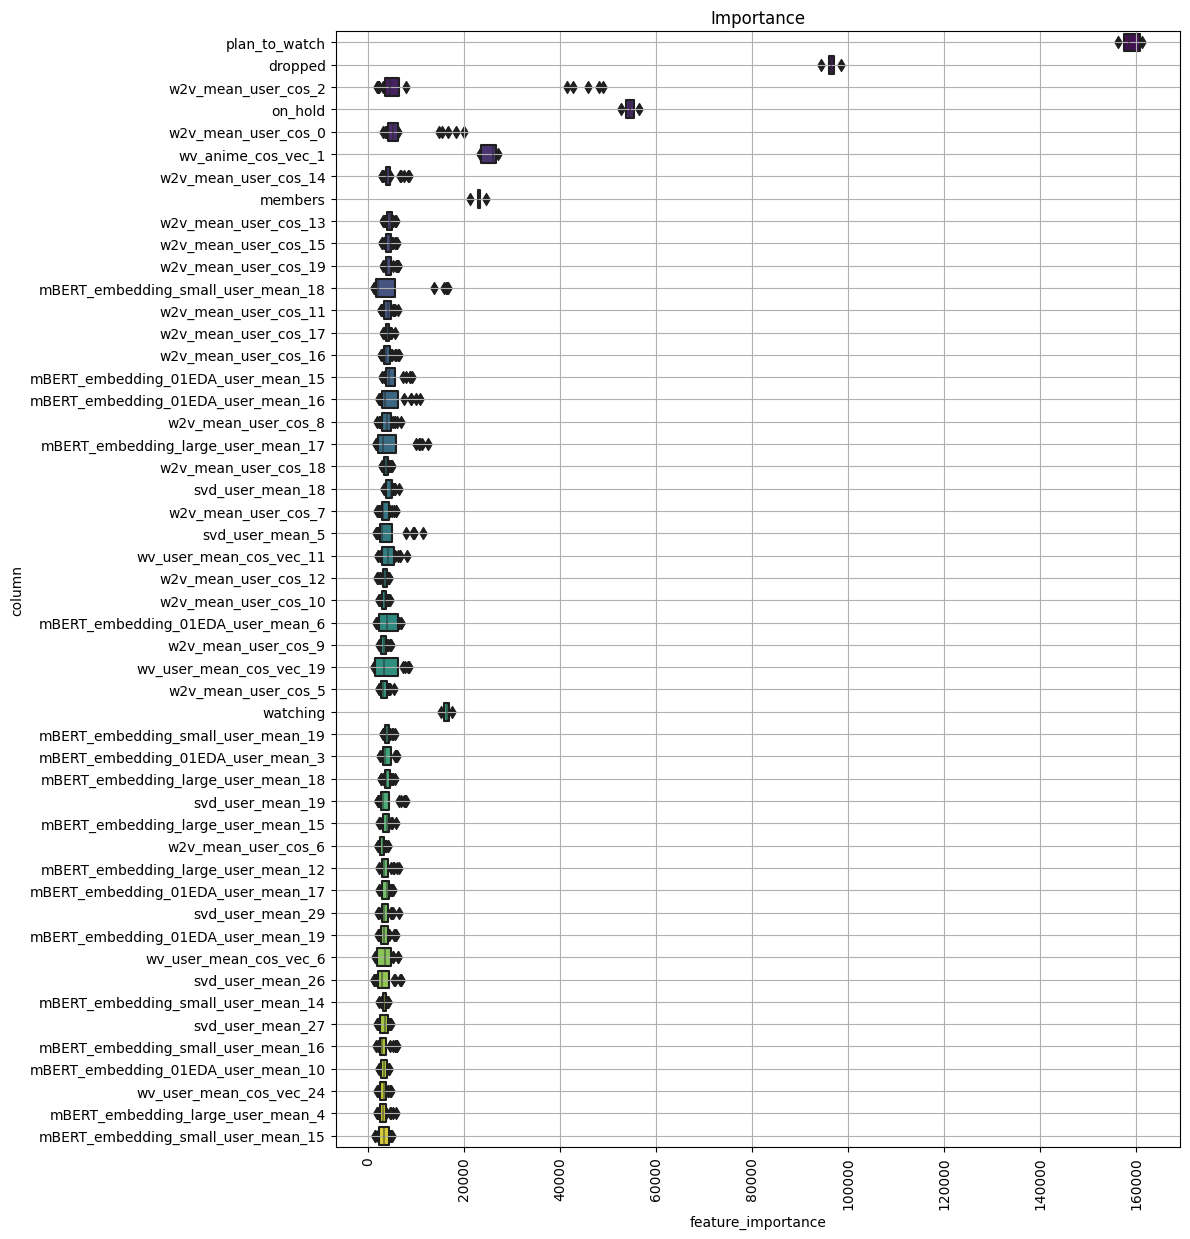

In [23]:

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        # _df["feature_importance"] = model.feature_importances_
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax
# fig, ax = visualize_importance(models, train_feat_df)
fig, ax = visualize_importance(models_lgb, train_feat_df)

In [24]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_feat_df.values) for model in tqdm(models_lgb)])
# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) # axis=0 なので shape の `k` が潰れる 

  0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
score = pd.DataFrame({
    "score": pred
})
score['score'] = score['score'].apply(lambda x: np.clip(x, 1, 10))
score.round(2).to_csv("submission_2.csv", index=False)